<a href="https://colab.research.google.com/github/ryoungj/ObsScaling/blob/main/instruct_llm_agent_capability.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Agent Capability Scaling Analysis

This notebook shows how to apply observational scaling laws to analyze how LMs' agentic capabilities (measured by agent benchmarks) scale with their principal capabilities (measured by standard LLM benchmarks). This corresponds to Sec 4.2 of the paper.

## Preparation

Colab specific setup: uncomment the following lines in colab

In [ ]:
# ! git clone https://github.com/ryoungj/ObsScaling
# %cd ObsScaling
# ! pip install -r requirements.txt

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import re
import copy

from utils import *

In [2]:
%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Load Eval Data

Load benchmark eval results for instruct LLMs

In [3]:
instruct_llm_benchmark_eval = load_instruct_llm_benchmark_eval()

In [4]:
instruct_llm_benchmark_eval.head(8)

,Model,Model Family,Model Size (B),Pretraining Data Size (T),FLOPs (1E21),Arena-Elo,MTBench,MMLU,ARC-C,HellaSwag,Winogrande,TruthfulQA,GSM8K,HumanEval
0,gpt-4-0613,GPT-4,NaN,NaN,NaN,0.923985,0.918,0.864000,0.963000,0.953000,0.875000,0.590000,0.920000,0.871951
1,claude-2.0,Claude-2,NaN,NaN,NaN,0.844002,0.806,0.785000,0.910000,NaN,NaN,0.690000,0.880000,0.670732
2,claude-1.3,Claude-1,NaN,NaN,NaN,0.890413,0.790,0.770000,0.900000,NaN,NaN,0.620000,0.852000,0.615854
3,gpt-3.5-turbo-0613,GPT-3.5-Turbo,NaN,NaN,NaN,0.805283,0.839,0.700000,0.852000,0.855000,0.816000,0.470000,0.571000,0.774390
4,claude-instant-1.1,Claude-Instant,NaN,NaN,NaN,0.781730,0.785,0.734000,0.857000,NaN,NaN,0.660000,0.809000,0.591463
5,codellama-34b-instruct,Codellama-Instruct,34.0,2.52,514.08,0.601739,NaN,0.546217,0.542662,0.769169,0.745067,0.444375,0.230478,0.487805
6,vicuna-13b-v1.5,Vicuna,13.0,2.00,156.00,0.593335,0.657,0.562390,0.565700,0.810894,0.746646,0.510745,0.112964,0.213415
7,llama-2-70b-chat,Llama-2-Chat,70.0,2.00,840.00,0.706850,0.686,0.634535,0.645904,0.858793,0.805051,0.528047,0.266869,0.317073


Load agent eval results for instruct LLMs

In [5]:
eval_result_path = "./eval_results/instruct_llm_agent_eval.csv"

agent_eval = pd.read_csv(eval_result_path)

In [6]:
agent_eval.head(8)

,Model,ABench-OA,ABench-Code_OS,ABench-Code_DB,ABench-Code_KG,ABench-Game_DCG,ABench-Game_LTP,ABench-Game_HH,ABench-Web_WS,ABench-Web_WB,...,ABoard-Web_WS_PR,ABoard-Web_WS_SR,ABoard-Web_WA_PR,ABoard-Web_WA_SR,ABoard-Tool_TQ_PR,ABoard-Tool_TQ_SR,ABoard-Tool_TO_PR,ABoard-Tool_TO_SR,ABoard-Avg_PR,ABoard-Avg_SR
0,gpt-4-0613,4.01,42.4,32.0,58.8,74.5,16.6,78.0,61.1,29.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,claude-2.0,2.49,18.1,27.3,41.3,55.5,8.4,54.0,61.4,0.0,...,74.6,37.8,36.4,8.6,73.5,48.3,59.6,27.5,48.9,26.2
2,claude-1.3,2.44,9.7,22.0,38.9,40.9,8.2,58.0,55.7,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,gpt-3.5-turbo-0613,2.32,32.6,36.7,25.9,33.7,10.5,16.0,64.1,20.0,...,76.4,35.1,25.5,4.6,69.4,45.0,37.2,7.5,41.4,19.7
4,claude-instant-1.1,1.60,16.7,18.0,20.8,5.9,12.6,30.0,49.7,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,codellama-34b-instruct,0.96,2.8,14.0,23.5,8.4,0.7,4.0,52.1,20.0,...,71.7,23.5,21.2,4.1,60.0,13.3,48.8,7.5,30.0,7.6
6,vicuna-13b-v1.5,0.93,10.4,6.7,9.4,0.1,8.0,8.0,41.7,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,llama-2-70b-chat,0.78,9.7,13.0,8.0,21.3,0.0,2.0,5.6,19.0,...,53.6,13.1,11.6,3.3,48.3,0.0,38.6,0.0,23.8,4.5


Merge eval results

In [7]:
instruct_llm_eval_with_agent = pd.merge(instruct_llm_benchmark_eval, agent_eval, on="Model")

## Scaling Analysis

Setup arguments

In [8]:
# Benchmark metrics used for scaling predictions, the Arena-Elo or MTBench are not used (or needed)
USED_INSTRUCT_LLM_METRICS = ["MMLU", "ARC-C", "HellaSwag", "Winogrande",  "TruthfulQA", "GSM8K", "HumanEval"]

AGENT_PCA_PREPROCESS_KWARGS = copy.deepcopy(DEFAULT_PCA_PREPROCESS_KWARGS)
AGENT_PCA_PREPROCESS_KWARGS["imputation_metrics"] = USED_INSTRUCT_LLM_METRICS
AGENT_PCA_PREPROCESS_KWARGS["pca_metrics"] = USED_INSTRUCT_LLM_METRICS

AGENT_SETUP_KWARGS = {
    # Data preprocessing: PCA imputation and extraction
    **AGENT_PCA_PREPROCESS_KWARGS,

    # Non-lineariy: sigmoid with parametrized scale and shift
    "nonlinearity": "sigmoid-parametric",

    # Cutoff: the top 10% performing models are used for testing
    "split_method": "rank_by_y_metric",
    "test_limit": 0.1,

    # Reference family: use Llama-2-Chat for computing equivalent FLOPs
    "ref_model_family": "Llama-2-Chat",

    # Model families
    "df_groupby": "Model Family",  # group markers by model family
    "stylize_model_family": EVAL_INSTRUCT_MODEL_FAMILIES,  # stylize markers by model family
    "default_style_kwargs": {"s": 180},

    # Regression: ordinary least squares
    "reg_method": "ols",    
}

AGENT_PC_X_METRICS_LIST = [PC_METRIC_NUM_1, PC_METRIC_NUM_2, PC_METRIC_NUM_3, PC_METRIC_NUM_4]

Helper functions

In [9]:
def filter_eval_df(
        agent_eval_df, 
        drop_entire_aboard=False,
        drop_detailed_aboard=True,
        drop_entire_abench=False,
        drop_detailed_abench=True,
    ):
    all_columns = agent_eval_df.columns

    if drop_entire_aboard:
        all_columns = [col for col in all_columns if not col.startswith("ABoard-")]

        # Only maintain AgentBench results and sort df by it
        agent_eval_df = agent_eval_df[agent_eval_df["ABench-OA"].notna()].sort_values("ABench-OA", ascending=False)
    elif drop_detailed_aboard:
        all_columns = [col for col in all_columns if not (col.startswith("ABoard-") and col != "ABoard-Avg_PR" and col != "ABoard-Avg_SR")]
    
    if drop_entire_abench:
        all_columns = [col for col in all_columns if not col.startswith("ABench-")]

        # Only maintain AgentBoard results and sort df by it
        agent_eval_df = agent_eval_df[agent_eval_df["ABoard-Avg_PR"].notna()].sort_values("ABoard-Avg_PR", ascending=False)
    elif drop_detailed_abench:
        all_columns = [col for col in all_columns if not (col.startswith("ABench-") and col != "ABench-OA")]
    
    return agent_eval_df[all_columns]

### AgentBench

In [10]:
abench_eval = filter_eval_df(instruct_llm_eval_with_agent, drop_entire_aboard=True)

abench_y_metric = "Overall Score"
abench_eval[abench_y_metric] = abench_eval["ABench-OA"]

abench_setup_kwargs = AGENT_SETUP_KWARGS.copy()
abench_setup_kwargs.update({
    "y_metric_process_funcs": "minmax_norm", 
    "y_metric_range": [0.0, 10.0],
})

Predict the scaling of agent performance with PCs 

Note: Compute measures are not available for close-source models and are thus not applicable

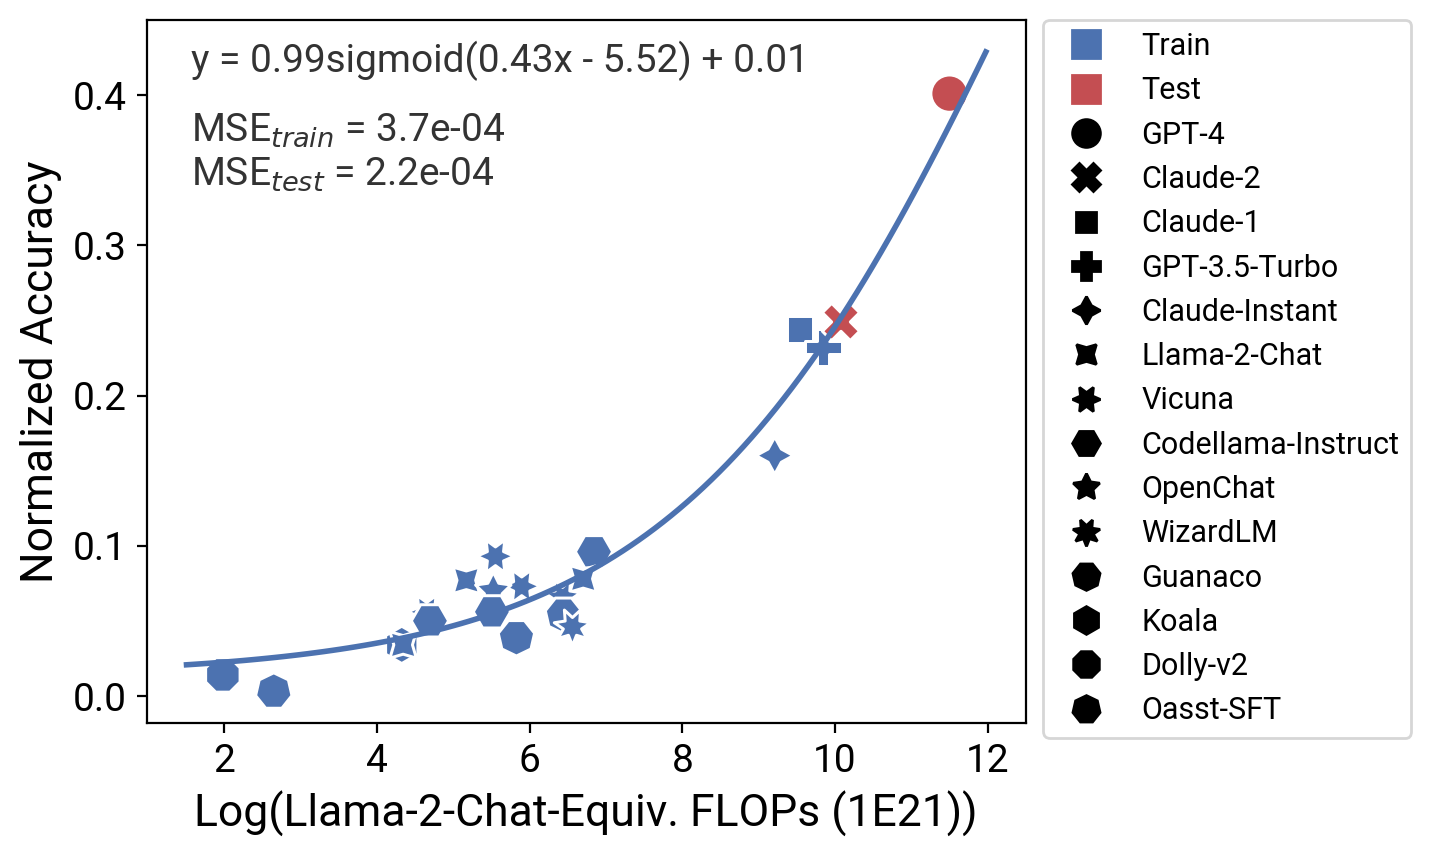

In [11]:
plt.figure(figsize=(7.4, 4.5))
_ = plot_scaling_predictions(
    abench_eval, PC_METRIC_NUM_3, abench_y_metric, 
    **abench_setup_kwargs,
)

Visualize the fitted weights on benchmark metrics

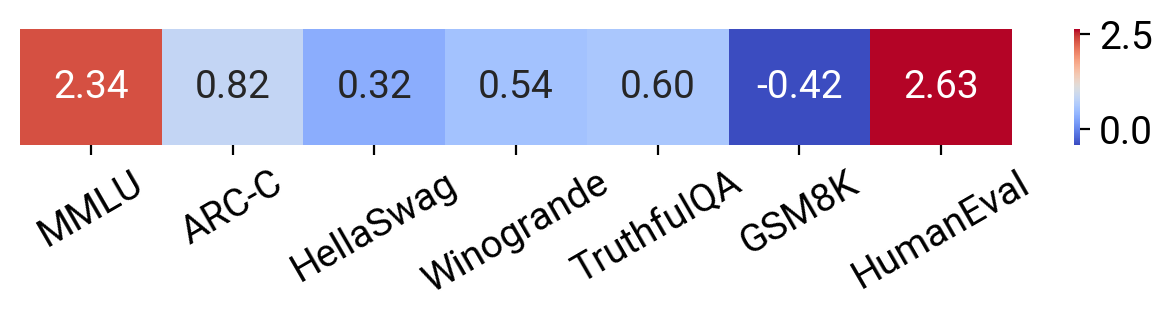

In [12]:
fig = plot_weight_analysis(
    abench_eval, {abench_y_metric: abench_y_metric}, [PC_METRIC_NUM_3], abench_setup_kwargs, 
)

Compare the scaling predictions using different number of PCs

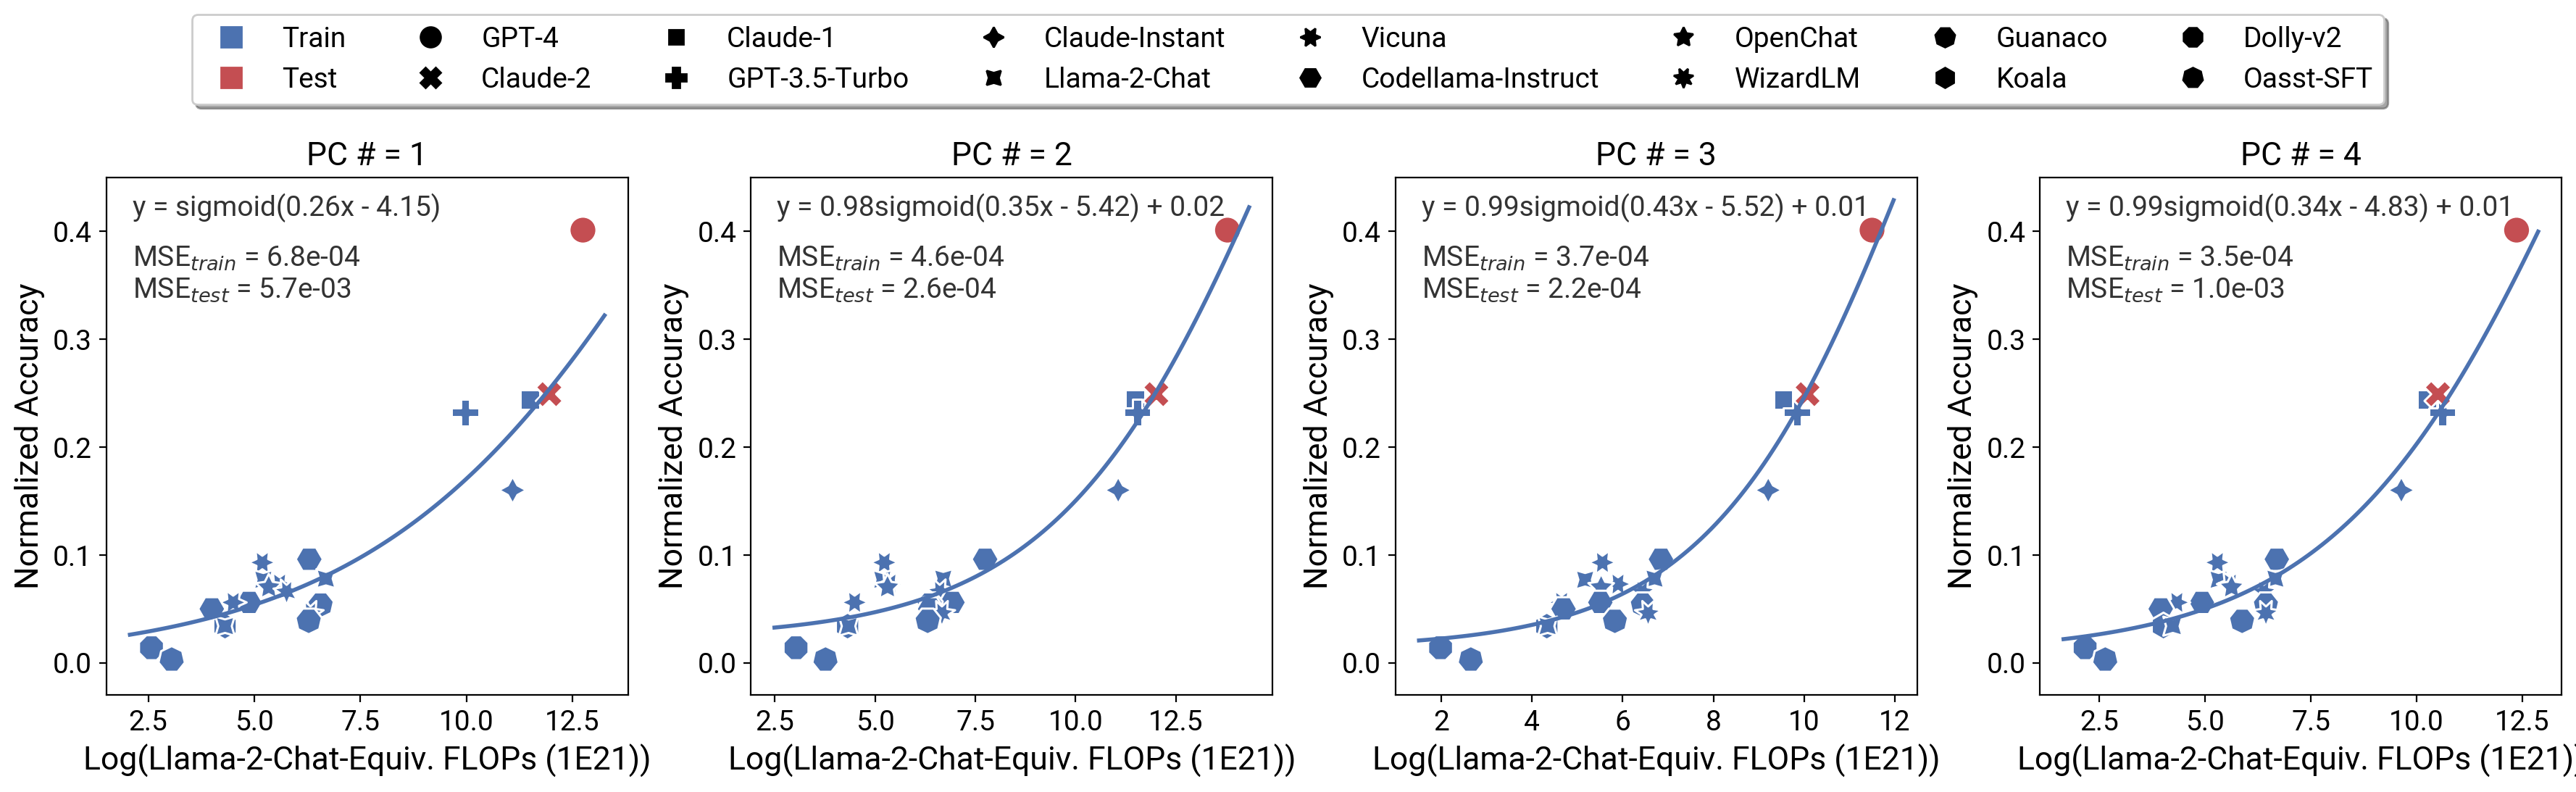

In [13]:
abench_compare_setup_kwargs = copy.deepcopy(abench_setup_kwargs)
abench_compare_setup_kwargs["plot_adjust_kwargs"] = {"ylim": [-0.03, 0.45]}


fig = plot_multi_scaling_predictions(
    abench_eval, [abench_y_metric], AGENT_PC_X_METRICS_LIST, abench_compare_setup_kwargs, 
    plot_legend=True, legend_nrow=2, transpose=True,
)

### AgentBoard

In [14]:
aboard_eval = filter_eval_df(instruct_llm_eval_with_agent, drop_entire_abench=True)
# aboard_eval

In [15]:
aboard_y_metric = "Average Success Rate"
aboard_eval[aboard_y_metric] = aboard_eval["ABoard-Avg_SR"] / 100

aboard_setup_kwargs = AGENT_SETUP_KWARGS.copy()
aboard_setup_kwargs.update({
    "grace_range_ratios": [0.05, 0.1],
})

Predict the scaling of agent performance with PCs

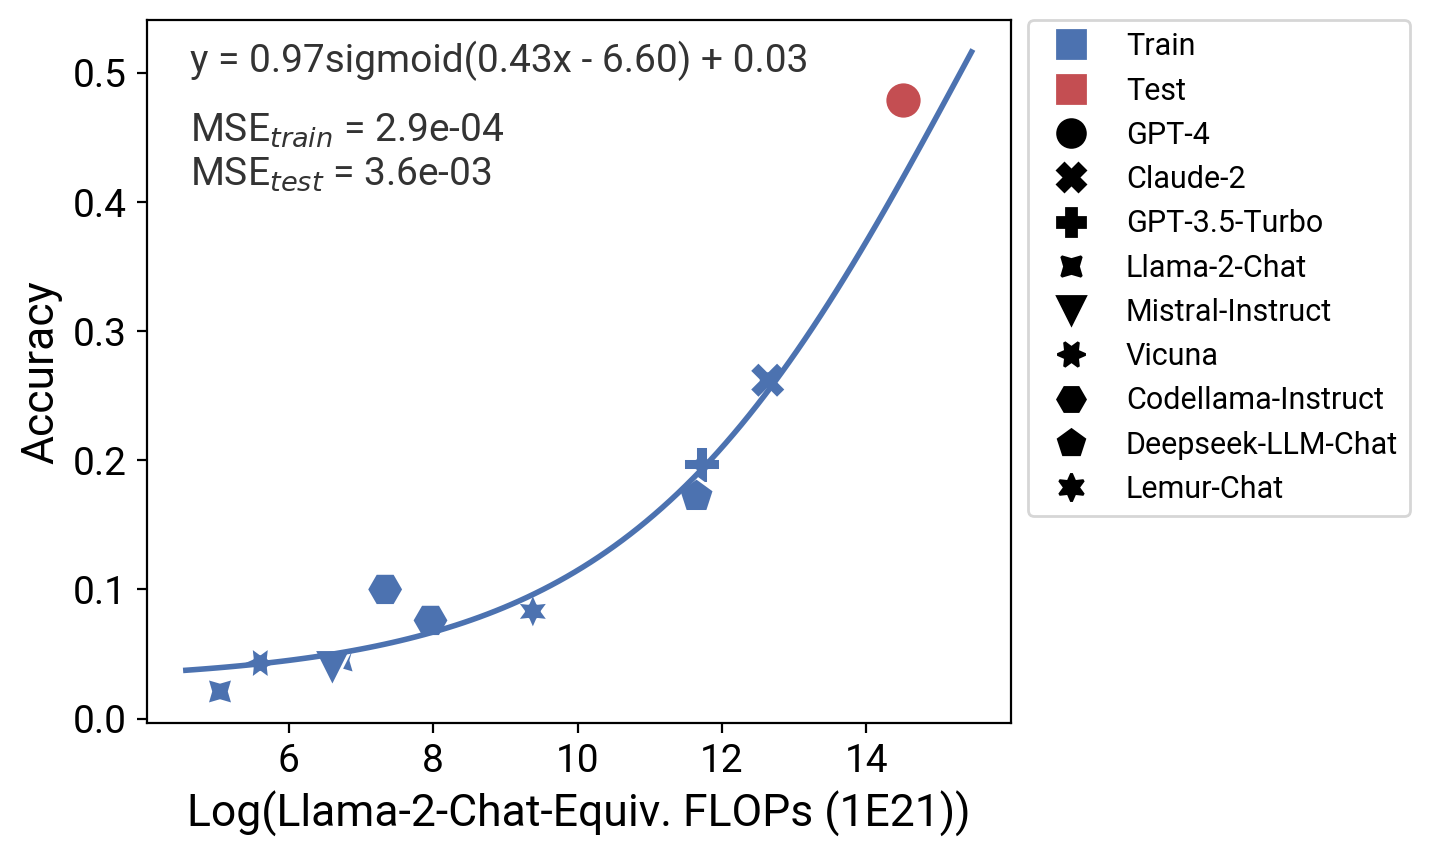

In [16]:
plt.figure(figsize=(7.4, 4.5))
_ = plot_scaling_predictions(
    aboard_eval, PC_METRIC_NUM_3, aboard_y_metric, 
    **aboard_setup_kwargs,
)

Visualize the fitted weights on benchmark metrics

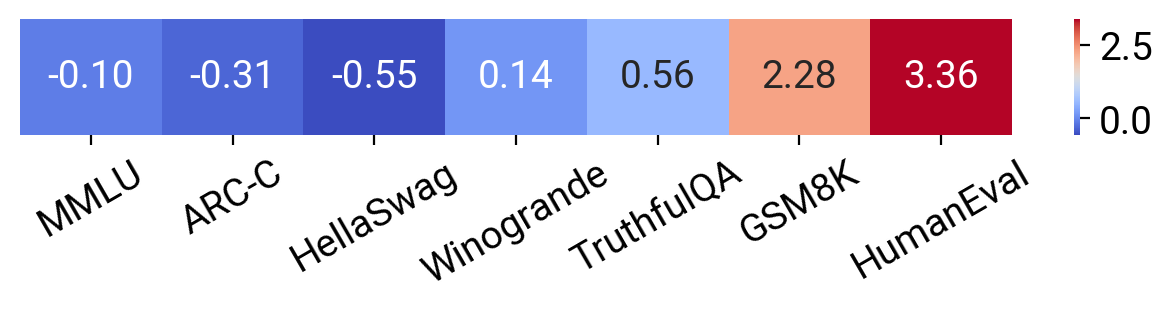

In [17]:
fig = plot_weight_analysis(
    aboard_eval, {aboard_y_metric: aboard_y_metric}, [PC_METRIC_NUM_3], aboard_setup_kwargs, 
)

Compare the scaling predictions using different number of PCs

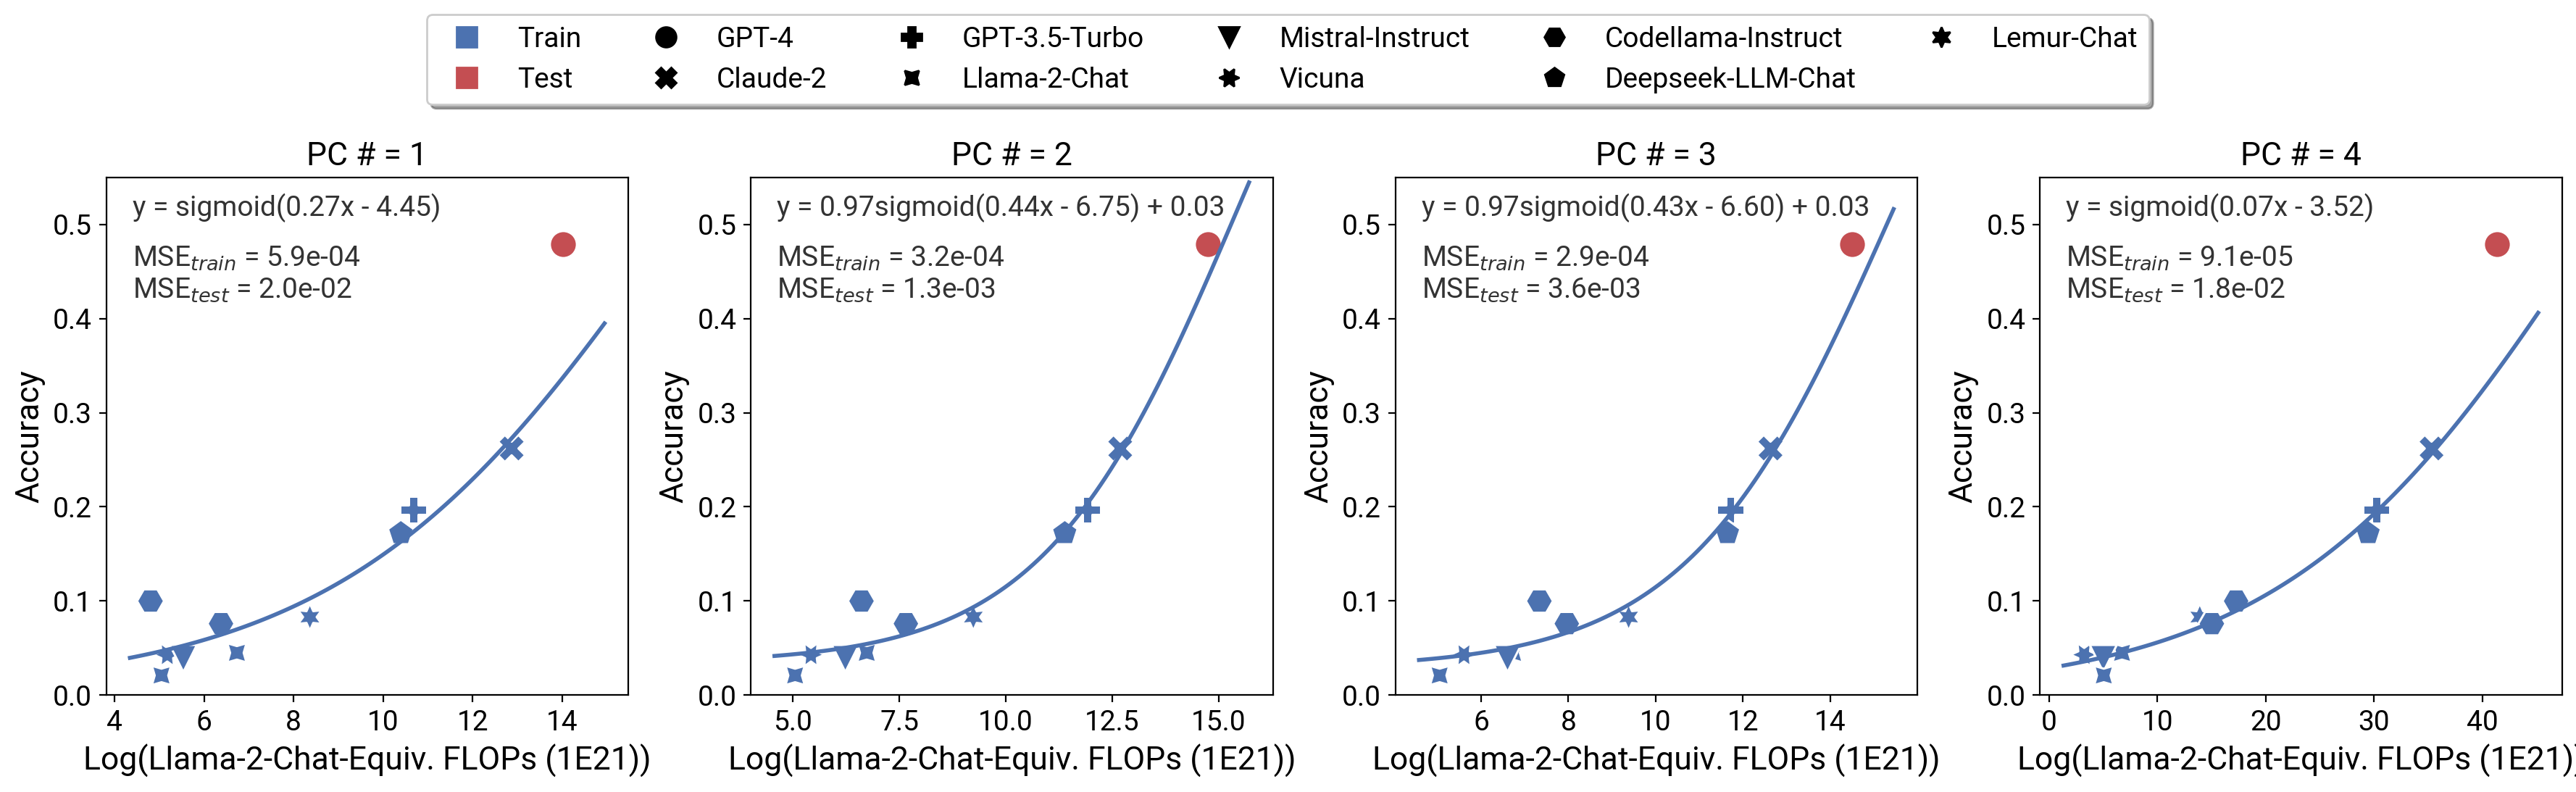

In [18]:
aboard_compare_setup_kwargs = copy.deepcopy(aboard_setup_kwargs)

aboard_compare_setup_kwargs["plot_adjust_kwargs"] = {"ylim": [0.0, 0.55]}

fig = plot_multi_scaling_predictions(
    aboard_eval, [aboard_y_metric], AGENT_PC_X_METRICS_LIST, aboard_compare_setup_kwargs, 
    plot_legend=True, legend_nrow=2, transpose=True,
)